In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier



plt.style.use('default')

trainData = pd.read_csv('/content/train.csv')
testData = pd.read_csv('/content/test.csv')
result = pd.read_csv('/content/gender_submission.csv')

testData = pd.concat([testData, result["Survived"]], axis=1)

Training DataSet:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
Test DataSet:
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
Survived     0
dtype: int64
qtd de idades inválidas: 0


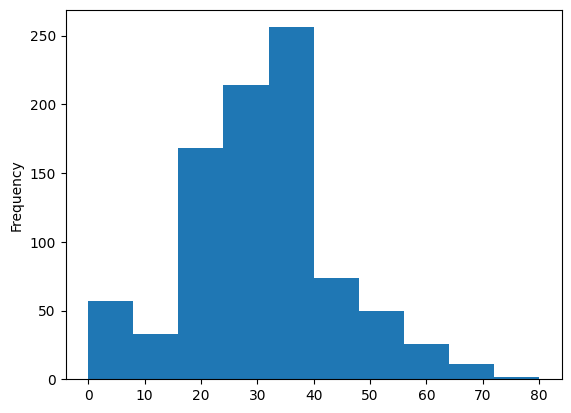

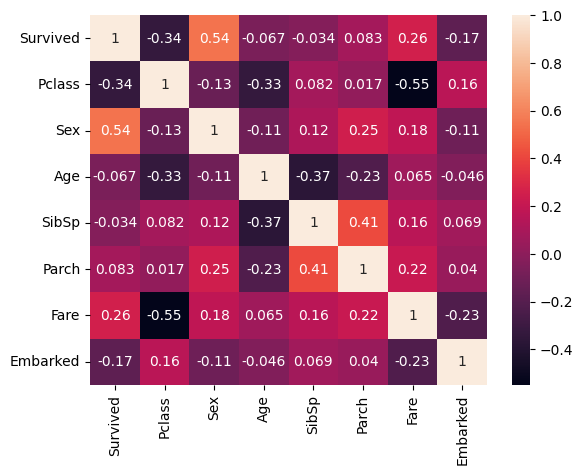

Valores não relacionados:
Age      0.066552
SibSp    0.034040
Parch    0.083151
Name: Survived, dtype: float64


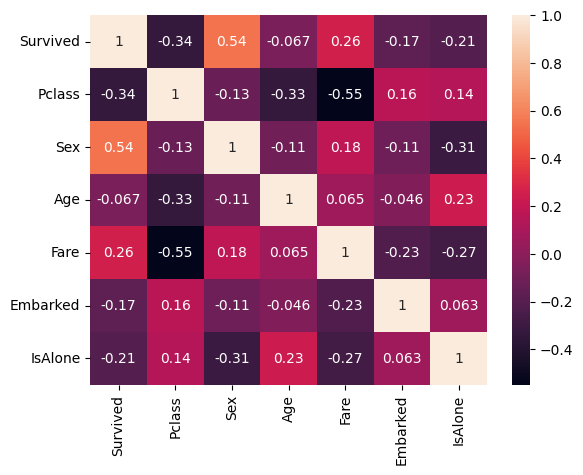

Valores não relacionados:
Age    0.066552
Name: Survived, dtype: float64
Sem limitação de profundidade - Accuracy: 0.8660287081339713
Sem limitação de profundidade - Confusion Matrix:
[[243  23]
 [ 33 119]]


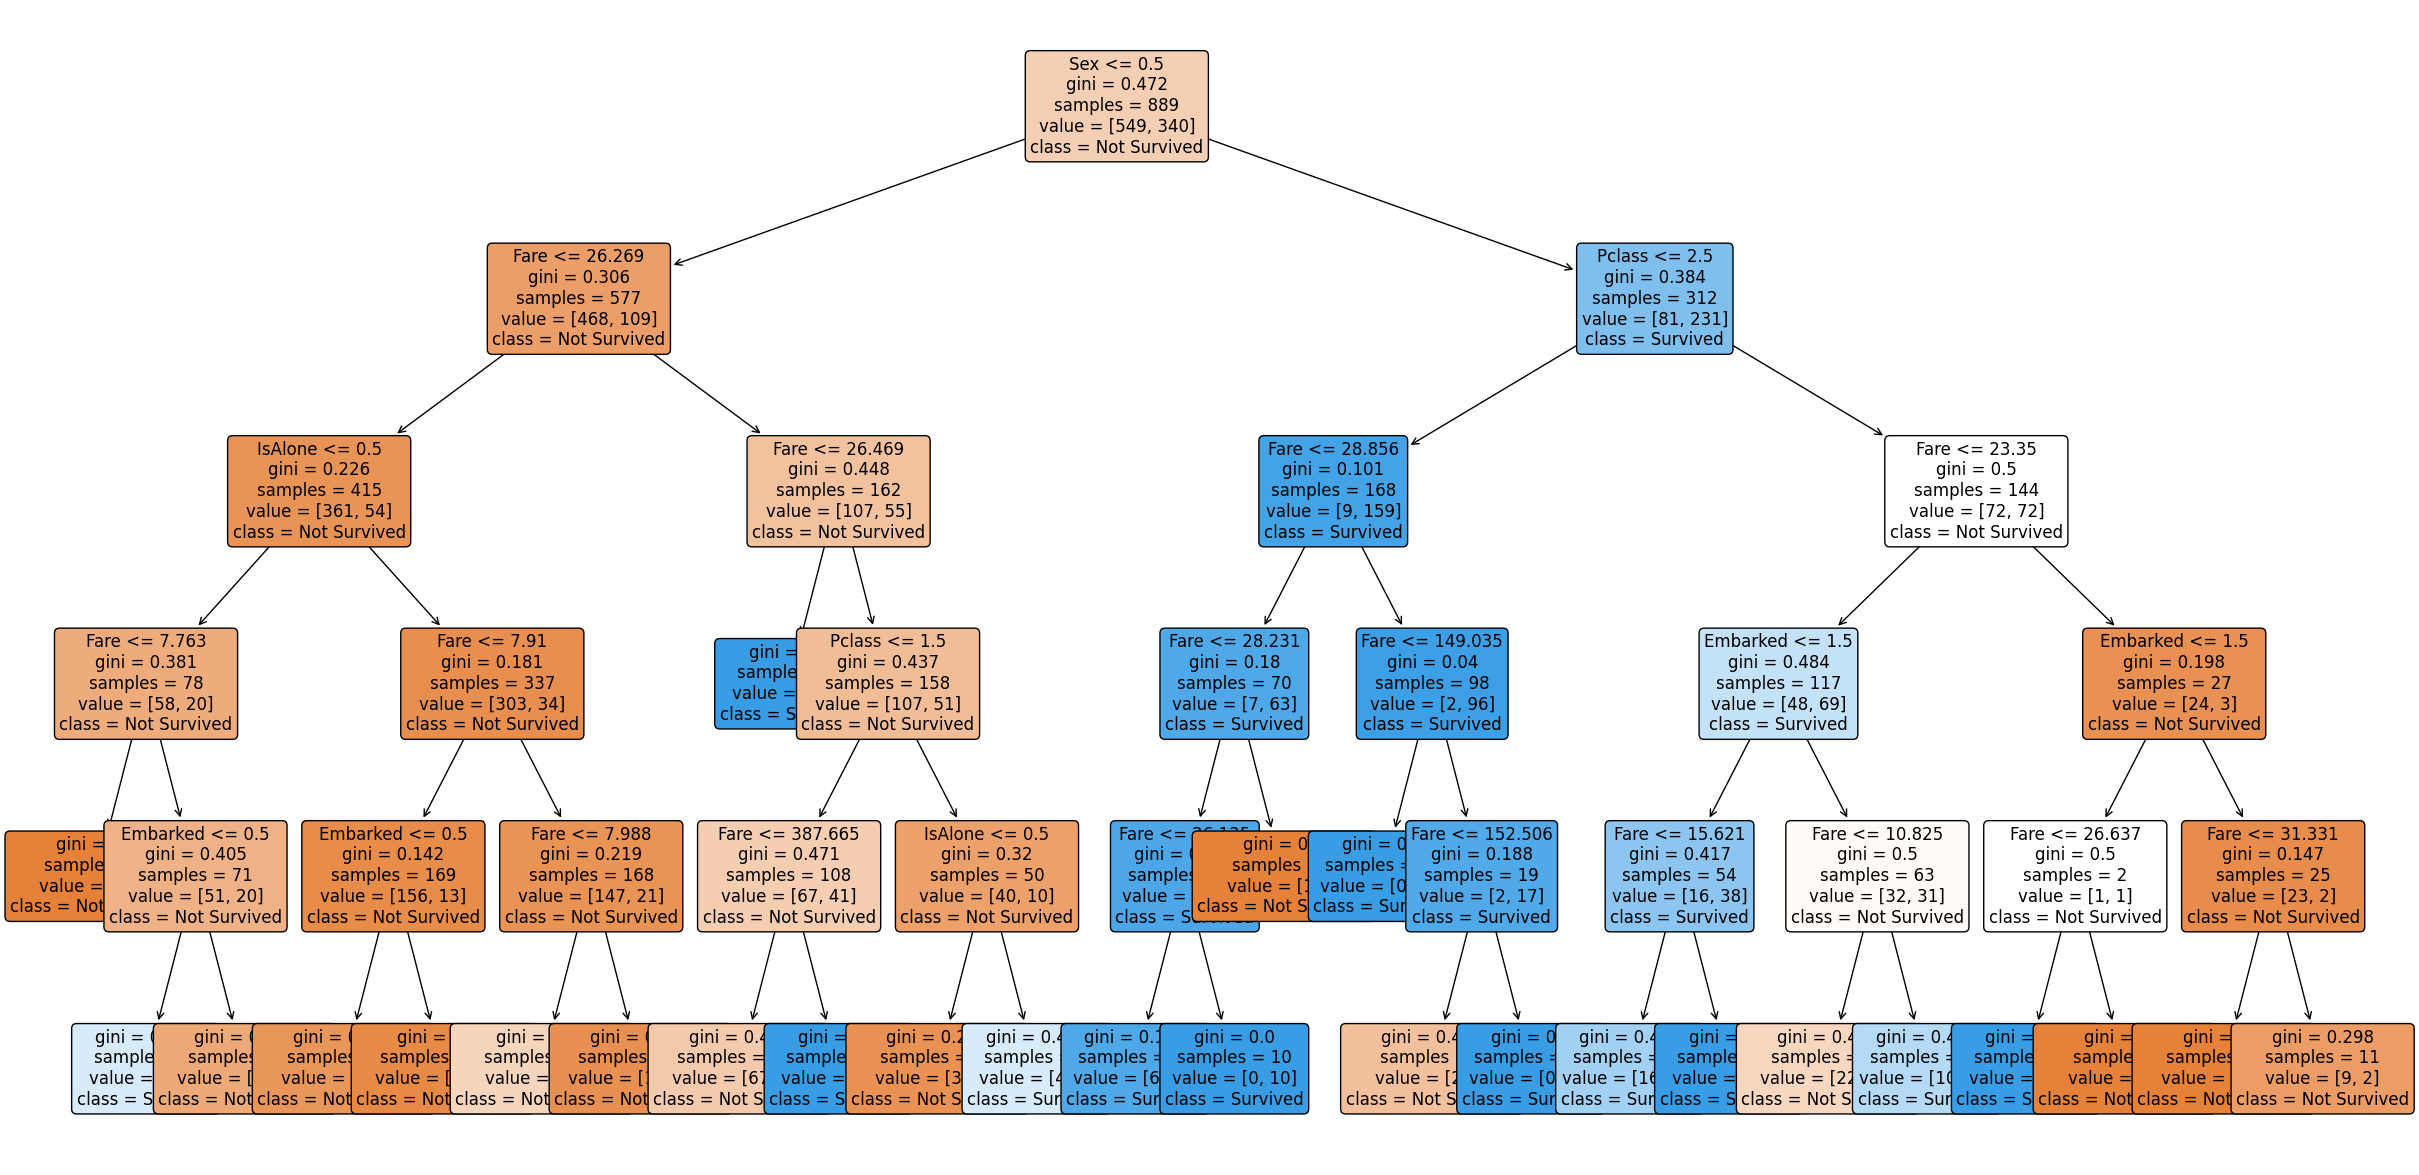

Com limitação de profundidade (max_depth=5) - Accuracy: 0.9043062200956937
Com limitação de profundidade (max_depth=5) - Confusion Matrix:
[[251  15]
 [ 25 127]]
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor precisão: 0.8211705706849489
Com os melhores parâmetros encontrados, incluindo max_depth - Accuracy: 0.8803827751196173
Com os melhores parâmetros encontrados, incluindo max_depth - Confusion Matrix:
[[251  15]
 [ 35 117]]
Média da Accuracy com limitação de profundidade (max_depth=5): 0.8622912462343892
Média da Confusion Matrix com limitação de profundidade (max_depth=5):
[[152.   11. ]
 [ 25.   73.4]]


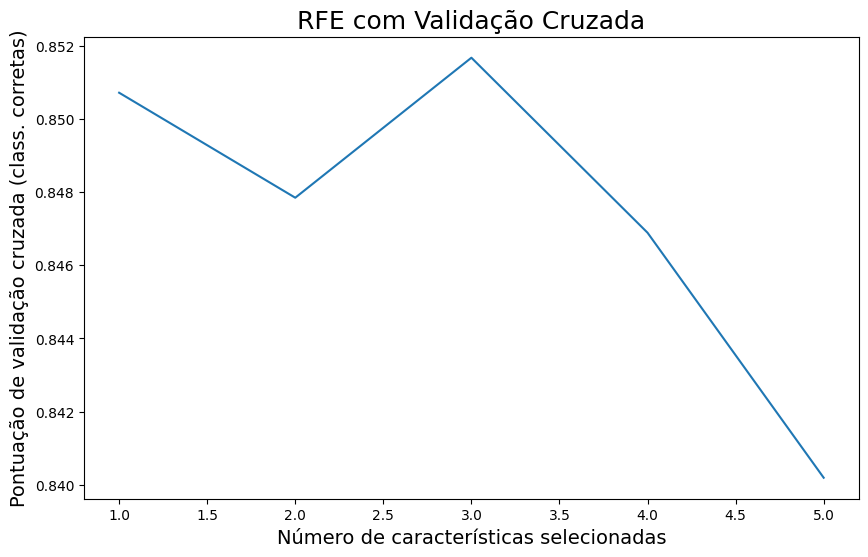

Número ótimo de características: 3
Características selecionadas: ['Pclass', 'Sex', 'Fare']
Melhor ccp_alpha: 0.00297098467469125
Acurácia do melhor modelo no conjunto de teste: 0.8854961832061069


In [ ]:
trainData = trainData.drop(["Cabin","Ticket","Name", "PassengerId"], axis=1)
testData = testData.drop(["Cabin","Ticket","Name", "PassengerId"], axis=1)

print("Training DataSet:")
print(trainData.isna().sum())
print("Test DataSet:")
print(testData.isna().sum())

columns = ["SibSp", "Parch", "Age"]
imputer = IterativeImputer(min_value = 0)

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
trainData["Age"] = correctedValues["Age"]

imputedValues = imputer.fit_transform(testData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
testData["Age"] = correctedValues["Age"]

trainData["Age"].plot(kind='hist')
print(f"qtd de idades inválidas: {trainData['Age'].isna().sum()}")

#Valores faltando na taxa de embarque => média
trainData["Fare"] = trainData["Fare"].replace(np.NaN, trainData["Fare"].mean())
testData["Fare"] = testData["Fare"].replace(np.NaN, testData["Fare"].mean())

#converter em valores numéricos
trainData["Sex"] = trainData["Sex"].map({"male": 0, "female": 1})
testData["Sex"] = testData["Sex"].map({"male": 0, "female": 1})

trainData["Embarked"] = trainData["Embarked"].map({"C": 0, "Q": 1, "S": 2})
testData["Embarked"] = testData["Embarked"].map({"C": 0, "Q": 1, "S": 2})

#removo qualquer NaN remanescente.
trainData = trainData.dropna().reset_index(drop=True)
testData = testData.dropna().reset_index(drop=True)

#Vizualizar quais váriaveis são mais correlacionadas com a de sobrevivência
matrix = trainData.corr()
plt.figure()
sns.heatmap(matrix, annot=True)
plt.show()

corrSurvived = abs(matrix["Survived"])
print(f"Valores não relacionados:\n{corrSurvived[corrSurvived < 0.1]}")

#Criamos essa coluna temporaria "FamilyCount" somando a qtd de filhos e de conjugues ao passageiro
#O dado mais relevante é saber se o passageiro está sozinho ou não.
trainData["FamilyCount"] = trainData['SibSp'] + trainData['Parch'] + 1
testData["FamilyCount"] = testData['SibSp'] + testData['Parch'] + 1
trainData['IsAlone'] = trainData["FamilyCount"] == 1
testData['IsAlone'] = testData["FamilyCount"] == 1

trainData = trainData.drop(["SibSp","Parch", "FamilyCount"], axis=1)
testData = testData.drop(["SibSp","Parch", "FamilyCount"], axis=1)

#Vizualizar quais váriaveis são mais correlacionadas com a de sobrevivência
matrix = trainData.corr()
plt.figure()
sns.heatmap(matrix, annot=True)
plt.show()

corrSurvived = abs(matrix["Survived"])
print(f"Valores não relacionados:\n{corrSurvived[corrSurvived < 0.1]}")

#idade continua pouco correlacionado à sobrevivência, então podemos remover

trainData = trainData.drop(["Age"], axis=1)
testData = testData.drop(["Age"], axis=1)

trainX = trainData.drop(["Survived"], axis=1)
trainY = trainData["Survived"]

testX = testData.drop(["Survived"], axis=1)
testY = testData["Survived"]

model_no_limit = DecisionTreeClassifier(random_state=42)
model_no_limit.fit(trainX, trainY)
y_pred_no_limit = model_no_limit.predict(testX)
accuracy_no_limit = accuracy_score(testY, y_pred_no_limit)
conf_matrix_no_limit = confusion_matrix(testY, y_pred_no_limit)
print(f'Sem limitação de profundidade - Accuracy: {accuracy_no_limit}')
print(f'Sem limitação de profundidade - Confusion Matrix:\n{conf_matrix_no_limit}')

model = DecisionTreeClassifier(max_depth=5)
model.fit(trainX, trainY)

# Plotando a árvore de decisão
plt.figure(figsize=(30, 15))
plot_tree(
    model,
    filled=True,
    feature_names=trainX.columns,
    class_names=['Not Survived', 'Survived'],
    rounded=True,
    proportion=False,
    fontsize=12
)
plt.show()

model_with_limit = DecisionTreeClassifier(max_depth=5)
model_with_limit.fit(trainX, trainY)
y_pred_with_limit = model_with_limit.predict(testX)
accuracy_with_limit = accuracy_score(testY, y_pred_with_limit)
conf_matrix_with_limit = confusion_matrix(testY, y_pred_with_limit)
print(f'Com limitação de profundidade (max_depth=5) - Accuracy: {accuracy_with_limit}')
print(f'Com limitação de profundidade (max_depth=5) - Confusion Matrix:\n{conf_matrix_with_limit}')

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 20, 40, 60, 80],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=42)

# Configuração do GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(trainX, trainY)

# Melhores parâmetros encontrados pelo GridSearchCV
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor precisão:", grid_search.best_score_)

# Avaliação do modelo com os melhores parâmetros no conjunto de teste
best_model_with_limit = grid_search.best_estimator_
y_pred_with_limit = best_model_with_limit.predict(testX)
accuracy_with_limit = accuracy_score(testY, y_pred_with_limit)
conf_matrix_with_limit = confusion_matrix(testY, y_pred_with_limit)

print(f'Com os melhores parâmetros encontrados, incluindo max_depth - Accuracy: {accuracy_with_limit}')
print(f'Com os melhores parâmetros encontrados, incluindo max_depth - Confusion Matrix:\n{conf_matrix_with_limit}')

totalDataSet = pd.concat([trainData,testData])
X = totalDataSet.drop(["Survived"], axis=1)
Y = totalDataSet["Survived"]

accuracies = []
conf_matrices = []

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True)

for trainIndex, textIndex in stratified_cv.split(X, Y):
    f_trainX, f_testX = X.iloc[trainIndex], X.iloc[textIndex]
    f_trainY, f_testY = Y.iloc[trainIndex], Y.iloc[textIndex]

    model_with_limit = DecisionTreeClassifier(max_depth=5)
    model_with_limit.fit(f_trainX, f_trainY)

    y_pred_with_limit = model_with_limit.predict(f_testX)
    accuracies.append(accuracy_score(f_testY, y_pred_with_limit))
    conf_matrices.append(confusion_matrix(f_testY, y_pred_with_limit))

# Cálculo das métricas médias após a validação cruzada estratificada
mean_accuracy = np.mean(accuracies)
mean_conf_matrix = np.mean(conf_matrices, axis=0)

print(f'Média da Accuracy com limitação de profundidade (max_depth=5): {mean_accuracy}')
print(f'Média da Confusion Matrix com limitação de profundidade (max_depth=5):\n{mean_conf_matrix}')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=dt, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.title('RFE com Validação Cruzada', fontsize=18)
plt.xlabel('Número de características selecionadas', fontsize=14)
plt.ylabel('Pontuação de validação cruzada (class. corretas)', fontsize=14)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

print("Número ótimo de características: %d" % rfecv.n_features_)
selected_features = [f for f, s in zip(X_train.columns, rfecv.support_) if s]
print("Características selecionadas:", selected_features)

X_train_reduced = X_train[selected_features]
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train_reduced, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#Treinamento com diferentes valores de ccp_alpha para achar o melhor
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train_reduced, y_train)
    clfs.append(clf)

# Encontrar a melhor precisão no conjunto de teste reduzido
X_test_reduced = X_test[selected_features]
acc_scores = [accuracy_score(y_test, clf.predict(X_test_reduced)) for clf in clfs]
best_alpha = ccp_alphas[np.argmax(acc_scores)]
best_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
best_clf.fit(X_train_reduced, y_train)

# Avaliar a precisão do melhor modelo
y_pred_best = best_clf.predict(X_test_reduced)
accuracy_best = accuracy_score(y_test, y_pred_best)

print(f'Melhor ccp_alpha: {best_alpha}')
print(f'Acurácia do melhor modelo no conjunto de teste: {accuracy_best}')



# Random Forests

Random Forests opera construindo múltiplas árvores de decisão durante o treinamento e produzindo a classe que é a moda das classes (classificação) ou a média das previsões (regressão) das árvores individuais. Random forests corrige o hábito das árvores de decisão de se ajustarem excessivamente ao seu conjunto de treinamento

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(trainX, trainY)

y_pred_rf = rf.predict(testX)
accuracy_rf = accuracy_score(testY, y_pred_rf)
conf_matrix_rf = confusion_matrix(testY, y_pred_rf)

print(f'Random Forest - Accuracy: {accuracy_rf}')
print(f'Random Forest - Confusion Matrix:\n{conf_matrix_rf}')

Random Forest - Accuracy: 0.8827751196172249
Random Forest - Confusion Matrix:
[[246  20]
 [ 29 123]]


## StratifiedKFold

É uma técnica de validação cruzada que visa a preservar a proporção de classes de cada resposta no conjunto de dados original em cada "fold" (subconjunto) que é criado. Isso é particularmente útil em situações em que as classes não estão igualmente representadas (ou seja, uma classe pode ter muitas mais instâncias do que outra).

In [ ]:
model_rf_cv = RandomForestClassifier(random_state=42)
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_rf_cv, trainX, trainY, cv=cv_strat, scoring='accuracy')

print("Acurácias da Validação Cruzada: ", scores)
print("Acurácia Média: {:.2f}".format(np.mean(scores)))

Acurácias da Validação Cruzada:  [0.85955056 0.74157303 0.75842697 0.84269663 0.82485876]
Acurácia Média: 0.81


## Otimização de hiperparametros

Ele define um espaço de busca com diferentes valores para o número de árvores (n_estimators), profundidade máxima das árvores (max_depth), número mínimo de amostras para dividir um nó (min_samples_split), número mínimo de amostras em um nó folha (min_samples_leaf), e se o bootstrap (reamostragem com reposição) é utilizado (bootstrap). O Grid Search explora todas as combinações possíveis desses hiperparâmetros para encontrar a configuração que maximiza a acurácia do modelo. Ele faz isso realizando validação cruzada com 5 folds sobre o conjunto de treinamento (trainX, trainY). Após encontrar os melhores hiperparâmetros, o modelo com essa configuração ótima é avaliado no conjunto de teste (testX, testY) para verificar sua acurácia, fornecendo assim uma estimativa do desempenho do modelo otimizado em dados não vistos.

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(trainX, trainY)

print("Melhores Hiperparâmetros:", grid_search.best_params_)
print("Melhor Acurácia: {:.2f}".format(grid_search.best_score_))

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(testX)
accuracy = accuracy_score(testY, y_pred)
print("Acurácia no conjunto de teste: {:.2f}".format(accuracy))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores Hiperparâmetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Melhor Acurácia: 0.81
Acurácia no conjunto de teste: 0.89


Utiliza feature_importances_ do modelo otimizado para avaliar a importância de cada característica, sugerindo a remoção de características menos importantes para simplificar o modelo.

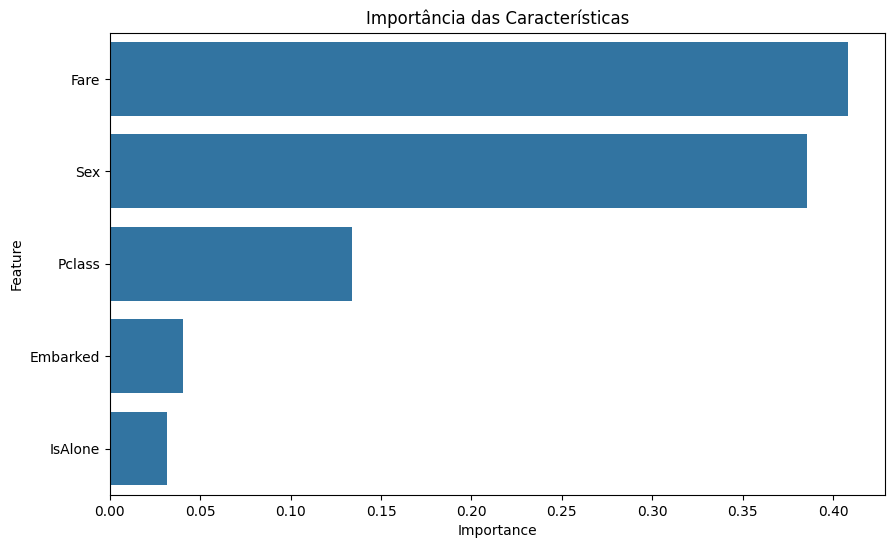

In [ ]:
feature_importances = best_rf.feature_importances_
features = trainX.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importância das Características')
plt.show()


# Considerando remover características com pouca importancia
selected_features = importance_df[importance_df['Importance'] > 0.01]['Feature']
trainX_selected = trainX[selected_features]
testX_selected = testX[selected_features]

## Análise de erros

Treina o modelo com características selecionadas, apresenta a matriz de confusão para visualizar os erros cometidos, ajudando a identificar padrões nos erros para ajustes futuros.

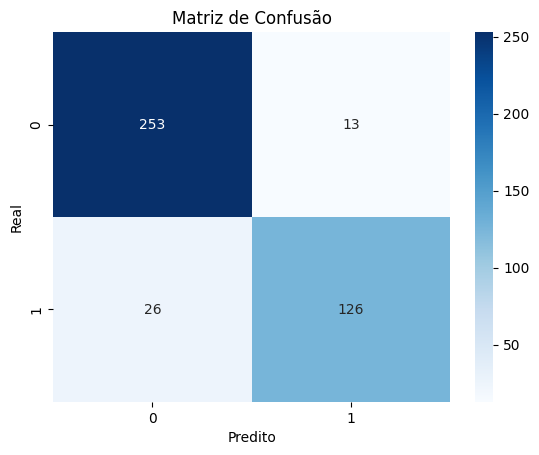

In [ ]:
best_rf.fit(trainX_selected, trainY)
y_pred_selected = best_rf.predict(testX_selected)

conf_matrix = confusion_matrix(testY, y_pred_selected)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

## Avaliação Final

Utiliza métricas de performance (acurácia, precisão, recall, F1-score) para avaliar a eficácia do modelo final, comparando com as métricas do modelo antes da otimização e análise de importância das características, proporcionando uma visão clara das melhorias alcançadas.

In [ ]:
accuracy = accuracy_score(testY, y_pred_selected)
precision = precision_score(testY, y_pred_selected)
recall = recall_score(testY, y_pred_selected)
f1 = f1_score(testY, y_pred_selected)

print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Acurácia: 0.9067
Precisão: 0.9065
Recall: 0.8289
F1-score: 0.8660


## Conclusão de Random Forest

O modelo Random Forest obteve um desempenho robusto na tarefa de classificação. A acurácia inicial de aproximadamente 88% no conjunto de teste indica que o modelo foi capaz de prever corretamente a maioria das instâncias.

A validação cruzada com 5 divisões (folds) apresentou acurácias variadas, sugerindo que o desempenho do modelo pode flutuar dependendo do subconjunto de dados em que é testado, mas ainda assim resultou em uma acurácia média satisfatória de 81%. Isso demonstra que o modelo tem uma generalização aceitável, apesar da variação nos resultados entre os folds.

A otimização dos hiperparâmetros do RandomForestClassifier via GridSearchCV demonstrou um aumento na acurácia do modelo para 90% no conjunto de teste, comparado a 81% na validação cruzada. Os hiperparâmetros escolhidos permitiram árvores complexas, mas as estratégias de regularização aplicadas ajudaram a evitar o overfitting. Isso indica que o modelo está bem ajustado, equilibrando a complexidade das árvores com a capacidade de generalizar para dados não vistos.

A análise da importância das características revelou quais variáveis foram mais relevantes para o modelo fazer suas previsões, sendo sex, PClass e fare, as principais. Após a remoção das características com pouca importância, o modelo manteve uma acurácia elevada de cerca de 89%. As métricas de precisão, recall e F1-score também são altas, indicando que o modelo é preciso e equilibrado na classificação das classes positivas e negativas. Especificamente, o F1-score de 0.8462 é particularmente notável, pois genrencia o trade-off entre as duas métricas precisão e recall, o modelo não está apenas identificando muitos dos casos positivos verdadeiros (alto recall), mas também está correto na maioria dessas identificações (alta precisão).